In [1]:
!export CUDA_VISIBLE_DEVICES=0

import os, torch, pdb

import numpy as np 
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot, init_notebook_mode, iplot
import plotly.express as px

from rdkit.Chem import AllChem

from escnn import gspaces, nn, group


from vae_dist.dataset.fields import mat_pull, split_and_filter
from vae_dist.dataset.dataset import FieldDataset, dataset_split_loader
from vae_dist.core.O3VAE import R3VAE
from vae_dist.core.R3CNN import R3CNN
from vae_dist.core.VAE import baselineVAEAutoencoder
from vae_dist.core.CNN import CNNAutoencoderLightning


init_notebook_mode(connected=True)


In [2]:
from vae_dist.core.training import construct_model 
import json 


options = json.load(open('./options/options_escnn_default.json'))
log_save_dir = "./log_version_escnn_1/"
model_escnn = construct_model("escnn", options)

options = json.load(open('./options/options_esvae_default.json'))
log_save_dir = "./log_version_esvae_1/"
model_esvae = construct_model("esvae", options)

options = json.load(open('./options/options_cnn_default.json'))
log_save_dir = "./log_version_auto_1/"
model_cnn = construct_model("auto", options)

options = json.load(open('./options/options_vae_default.json'))
log_save_dir = "./log_version_vae_1/"
model_vae = construct_model("vae", options)

model_escnn.load_model("./log_version_escnn_1/model_1.ckpt")
model_esvae.load_model("./log_version_esvae_1/model_1.ckpt")
model_cnn.load_model("./log_version_auto_1/model_1.ckpt")
model_vae.load_model("./log_version_vae_1/model_1.ckpt")

# load models to gpu
model_escnn.cuda()
model_esvae.cuda()
model_cnn.cuda()
model_vae.cuda()

/home/santiagovargas/anaconda3/envs/bondnet_e3nn/lib/python3.7/site-packages/torch/functional.py:478: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)



48 100
100 100
100 2
Model Created!
Model Created!
Model Created!
Model Created!


baselineVAEAutoencoder(
  (fc_mu): Linear(in_features=4, out_features=2, bias=True)
  (fc_var): Linear(in_features=4, out_features=2, bias=True)
  (encoder): Sequential(
    (0): ConvBatch(
      (conv): Sequential(
        (0): Conv3d(3, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=78608, out_features=4, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=78608, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(16, 17, 17, 17))
    (3): UpConvBatch(
      (up): Sequential(
        (0): ConvTranspose3d(16, 3, kernel_size=(5, 5, 5), stride=(1, 1, 1))
        (1): BatchNorm3d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): LeakyReLU(negative_slope=0.01)
    (5): Sigmoid()
 

In [3]:
dataset_test_loc = "../../data/augment_test/"
dataset_loc = "../../data/cpet/"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_test = FieldDataset(
    dataset_loc,
    transform=False,
    augmentation=False,
    standardize=True,
    device=device
)

dataset_aug = FieldDataset(
    dataset_test_loc, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )


142.4992747260671 4388.683312367696
Largest value in dataset:  468.95908588256685
Smallest value in dataset:  -471.608693838242
4.2071627193271235 280.7762035535068
Largest value in dataset:  50.51481750751459
Smallest value in dataset:  -54.68574620350573


In [4]:
def get_latent_space(model, dataset, comp=[0, 2], latent_dim=10):
    latent_space = []
    # convert load to numpy 
    dataset_loader_np = []
    print("Total number of fields: ", len(dataset))
    for ind in range(len(dataset)):
        field=dataset[ind].reshape(1, 3, 21, 21, 21)
        latent = model.latent(field)
        #print(latent.shape)
        latent_space.append(latent.detach().cpu().numpy())
    return np.array(latent_space).reshape(-1, latent_dim)[:, comp]




In [6]:
# get latent space on full set 
latent_space_escnn = get_latent_space(model_escnn, dataset_test, comp=[0, 1], latent_dim=2)
latent_space_esvae = get_latent_space(model_esvae, dataset_test, comp=[0, 1], latent_dim=2)
latent_space_cnn = get_latent_space(model_cnn, dataset_test, comp=[0, 1], latent_dim=2)
latent_space_vae = get_latent_space(model_vae, dataset_test, comp=[0, 1], latent_dim=2)
# get latent space on test flip set 
aug_space_escnn = get_latent_space(model_escnn, dataset_aug, comp=[0, 1], latent_dim=2)
aug_space_esvae = get_latent_space(model_esvae, dataset_aug, comp=[0, 1], latent_dim=2)
aug_space_cnn = get_latent_space(model_cnn, dataset_aug, comp=[0, 1], latent_dim=2)
aug_space_vae = get_latent_space(model_vae, dataset_aug, comp=[0, 1], latent_dim=2)




Total number of fields:  187
Total number of fields:  187
Total number of fields:  187
Total number of fields:  187
Total number of fields:  8
Total number of fields:  8
Total number of fields:  8
Total number of fields:  8


In [7]:
# print len of every set
print("Length of latent space: ", len(latent_space_escnn))
print("Length of augmented space: ", len(aug_space_escnn))

# print len of every set
print("Length of latent space: ", len(latent_space_esvae))
print("Length of augmented space: ", len(aug_space_esvae))

# print len of every set
print("Length of latent space: ", len(latent_space_cnn))
print("Length of augmented space: ", len(aug_space_cnn))

# print len of every set
print("Length of latent space: ", len(latent_space_vae))
print("Length of augmented space: ", len(aug_space_vae))

Length of latent space:  187
Length of augmented space:  8
Length of latent space:  187
Length of augmented space:  8
Length of latent space:  187
Length of augmented space:  8
Length of latent space:  187
Length of augmented space:  8


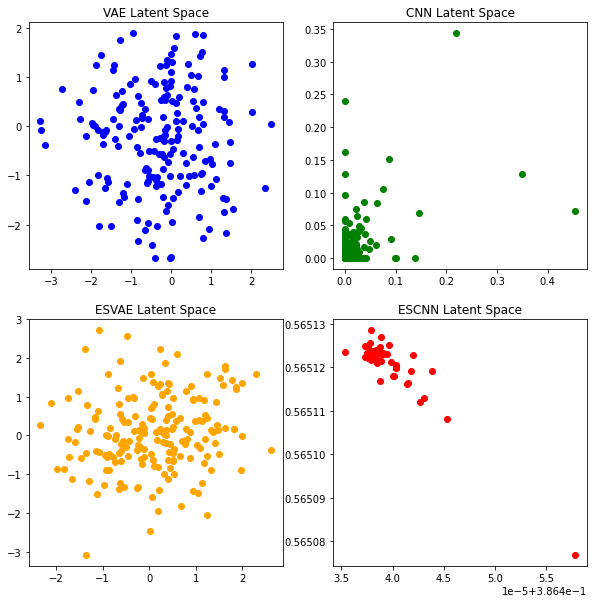

In [8]:
# plot latent space of each model in subplots with titles 
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(latent_space_vae[:, 0], latent_space_vae[:, 1], c="blue", label="test")
axs[0, 0].set_title("VAE Latent Space")
axs[0, 1].scatter(latent_space_cnn[:, 0], latent_space_cnn[:, 1], c="green", label="test")
axs[0, 1].set_title("CNN Latent Space")
axs[1, 0].scatter(latent_space_esvae[:, 0], latent_space_esvae[:, 1], c="orange", label="test")
axs[1, 0].set_title("ESVAE Latent Space")
axs[1, 1].scatter(latent_space_escnn[:, 0], latent_space_escnn[:, 1], c="red", label="test")
axs[1, 1].set_title("ESCNN Latent Space")
plt.show()


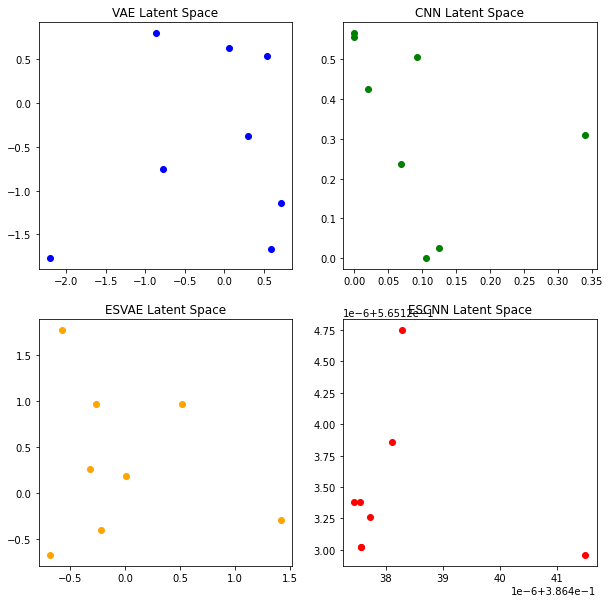

In [9]:
# repeat with augmented data
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(aug_space_vae[:, 0], aug_space_vae[:, 1], c="blue", label="test")
axs[0, 0].set_title("VAE Latent Space")
axs[0, 1].scatter(aug_space_cnn[:, 0], aug_space_cnn[:, 1], c="green", label="test")
axs[0, 1].set_title("CNN Latent Space")
axs[1, 0].scatter(aug_space_esvae[:, 0], aug_space_esvae[:, 1], c="orange", label="test")
axs[1, 0].set_title("ESVAE Latent Space")
axs[1, 1].scatter(aug_space_escnn[:, 0], aug_space_escnn[:, 1], c="red", label="test")
axs[1, 1].set_title("ESCNN Latent Space")
plt.show()

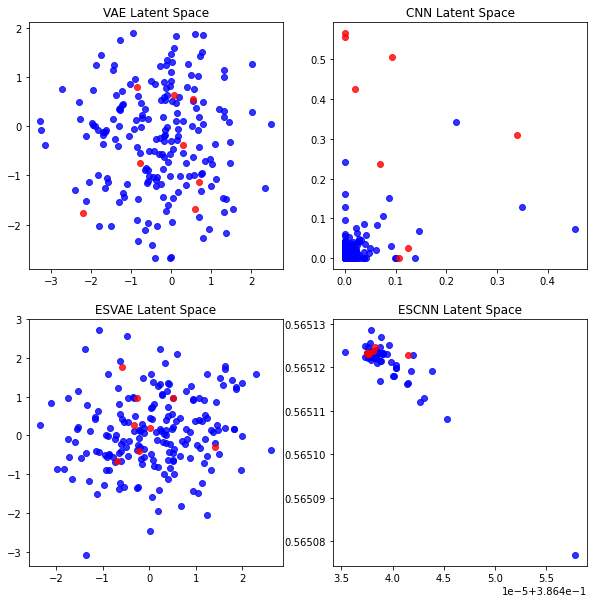

In [10]:
# plot both together
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter(latent_space_vae[:, 0], latent_space_vae[:, 1], c="blue", label="test", alpha=0.8)
axs[0, 0].scatter(aug_space_vae[:, 0], aug_space_vae[:, 1], c="red", label="aug", alpha=0.8)
axs[0, 0].set_title("VAE Latent Space")
axs[0, 1].scatter(latent_space_cnn[:, 0], latent_space_cnn[:, 1], c="blue", label="test", alpha=0.8)
axs[0, 1].scatter(aug_space_cnn[:, 0], aug_space_cnn[:, 1], c="red", label="aug", alpha=0.8)
axs[0, 1].set_title("CNN Latent Space")
axs[1, 0].scatter(latent_space_esvae[:, 0], latent_space_esvae[:, 1], c="blue", label="test", alpha=0.8)
axs[1, 0].scatter(aug_space_esvae[:, 0], aug_space_esvae[:, 1], c="red", label="aug", alpha=0.8)
axs[1, 0].set_title("ESVAE Latent Space")
axs[1, 1].scatter(latent_space_escnn[:, 0], latent_space_escnn[:, 1], c="blue", label="test", alpha=0.8)
axs[1, 1].scatter(aug_space_escnn[:, 0], aug_space_escnn[:, 1], c="red", label="aug", alpha=0.8)
axs[1, 1].set_title("ESCNN Latent Space")
plt.show()

In [11]:
# get distance, in latent space, between all the points 
def get_distance(latent_space):
    ret_mat = np.zeros((len(latent_space), len(latent_space)))
    dist = []
    # only iterate over half of the matrix, since it's symmetric
    for i in range(len(latent_space)):
        for j in range(i, len(latent_space)):
            dist_temp = np.linalg.norm(latent_space[i] - latent_space[j])
            ret_mat[i][j] = dist_temp
            ret_mat[j][i] = dist_temp
    return ret_mat
dist_mat = get_distance(latent_space_esvae)
dist_mat_aug = get_distance(aug_space_esvae)

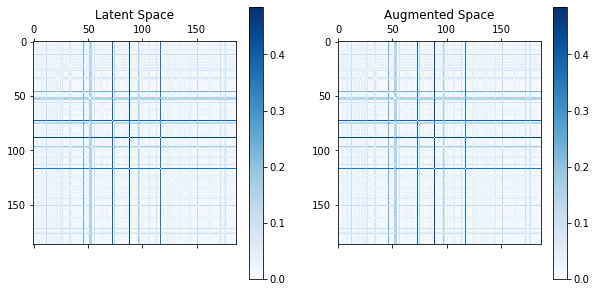

In [12]:
dist_mat = get_distance(latent_space_cnn)
dist_mat_aug = get_distance(latent_space_cnn)
# plot distance matrix as matrix for each dataset side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].matshow(dist_mat, cmap=plt.cm.Blues)
axs[0].set_title("Latent Space")
fig.colorbar(axs[0].matshow(dist_mat, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[0], shrink=0.5)

axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues)
axs[1].set_title("Augmented Space")
# add colorbar to each subplot
fig.colorbar(axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[1], shrink=0.5)
plt.show()


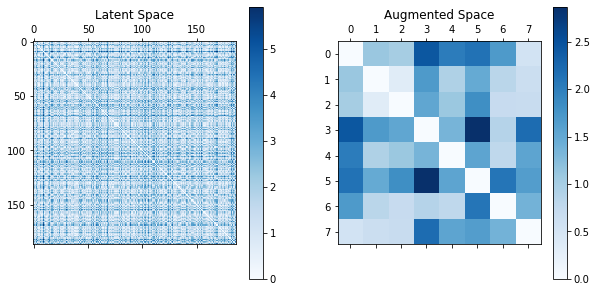

In [13]:
dist_mat = get_distance(latent_space_esvae)
dist_mat_aug = get_distance(aug_space_esvae)
# plot distance matrix as matrix for each dataset side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].matshow(dist_mat, cmap=plt.cm.Blues)
axs[0].set_title("Latent Space")
fig.colorbar(axs[0].matshow(dist_mat, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[0], shrink=0.5)

axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues)
axs[1].set_title("Augmented Space")
# add colorbar to each subplot
fig.colorbar(axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[1], shrink=0.5)
plt.show()

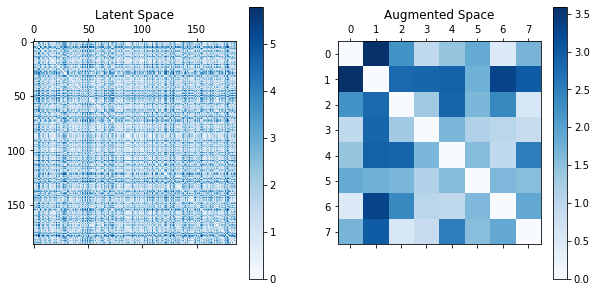

In [14]:
dist_mat = get_distance(latent_space_vae)
dist_mat_aug = get_distance(aug_space_vae)
# plot distance matrix as matrix for each dataset side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].matshow(dist_mat, cmap=plt.cm.Blues)
axs[0].set_title("Latent Space")
fig.colorbar(axs[0].matshow(dist_mat, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[0], shrink=0.5)

axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues)
axs[1].set_title("Augmented Space")
# add colorbar to each subplot
fig.colorbar(axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[1], shrink=0.5)
plt.show()

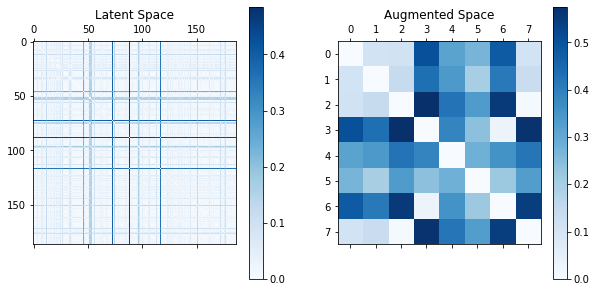

In [15]:
dist_mat = get_distance(latent_space_cnn)
dist_mat_aug = get_distance(aug_space_cnn)
# plot distance matrix as matrix for each dataset side-by-side
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].matshow(dist_mat, cmap=plt.cm.Blues)
axs[0].set_title("Latent Space")
fig.colorbar(axs[0].matshow(dist_mat, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[0], shrink=0.5)

axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues)
axs[1].set_title("Augmented Space")
# add colorbar to each subplot
fig.colorbar(axs[1].matshow(dist_mat_aug, cmap=plt.cm.Blues), ax=axs.ravel().tolist()[1], shrink=0.5)
plt.show()

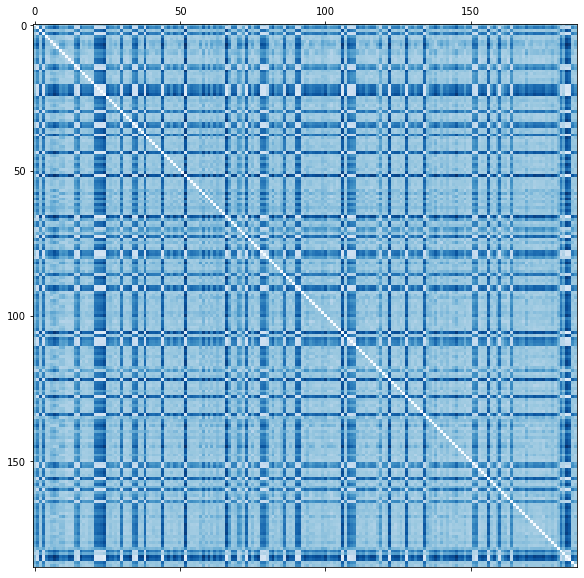

In [7]:
# read matrix from ../../data/distance_matrix_iron_set.dat
distance_loc = "../../data/distance_matrix_iron_set.dat"
distance_mat_cpet = np.loadtxt(distance_loc)
# plot matrix 
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.matshow(distance_mat_cpet, cmap=plt.cm.Blues)


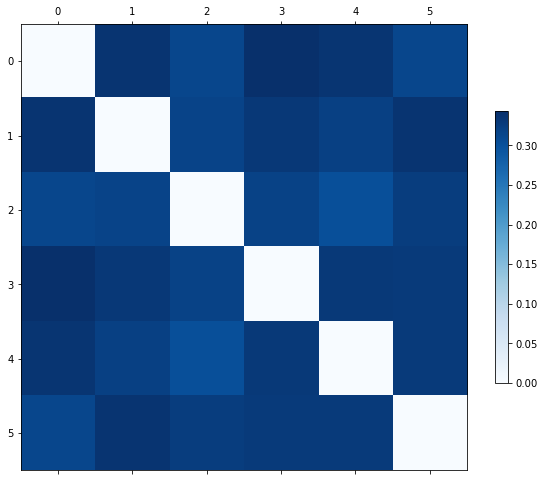

In [8]:
distance_loc = "../../data/distance_test_aug_cpet.dat"
distance_mat_cpet_aug = np.loadtxt(distance_loc)
# plot matrix 
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.matshow(distance_mat_cpet_aug, cmap=plt.cm.Blues)
# color bar
fig.colorbar(axs.matshow(distance_mat_cpet_aug, cmap=plt.cm.Blues), ax=axs, shrink=0.5)


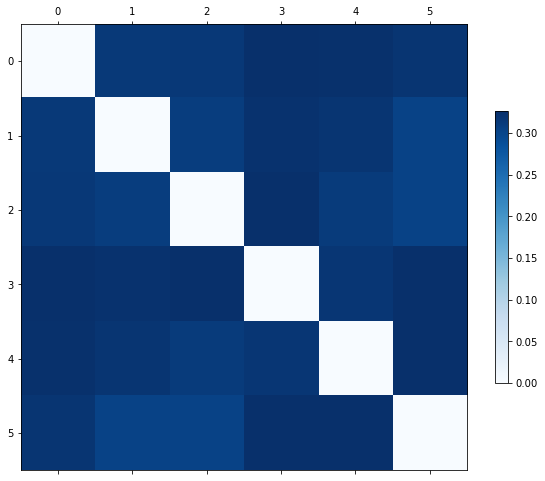

In [9]:
distance_loc = "../../data/dist_same.dat"
distance_mat_same = np.loadtxt(distance_loc)
# plot matrix 
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
axs.matshow(distance_mat_same, cmap=plt.cm.Blues)
# color bar
fig.colorbar(axs.matshow(distance_mat_same, cmap=plt.cm.Blues), ax=axs, shrink=0.5)

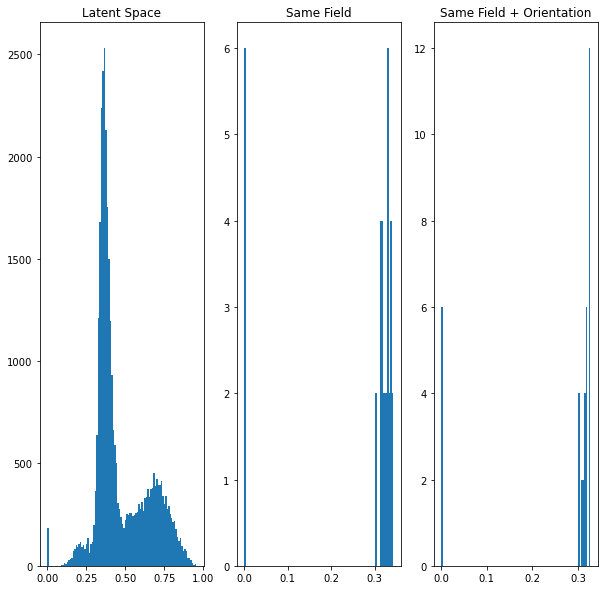

In [10]:
# plot the hist of distance_mat_cpet and distance_mat_cpet_aug
fig, axs = plt.subplots(1, 3, figsize=(10, 10))
axs[0].hist(distance_mat_cpet.flatten(), bins=100)
axs[0].set_title("Latent Space")
axs[1].hist(distance_mat_cpet_aug.flatten(), bins=100)
axs[1].set_title("Same Field")
axs[2].hist(distance_mat_same.flatten(), bins=100)
axs[2].set_title("Same Field + Orientation")
plt.show()

In [21]:
import scipy
# get first row of distance matrix and one of the computed ones and compute the correlation
def get_correlation(distance_mat, dist_mat):
    return scipy.stats.pearsonr(distance_mat[10], dist_mat[10])
# get correlation between distance matrix and computed distance matrix
dist_mat = get_distance(latent_space_vae)
print("ESVAE: ", get_correlation(distance_mat_cpet, dist_mat)[0])
dist_mat = get_distance(latent_space_esvae)
print("ESVAE: ", get_correlation(distance_mat_cpet, dist_mat)[0])
dist_mat = get_distance(latent_space_cnn)
print("CNN: ", get_correlation(distance_mat_cpet, dist_mat)[0])
dist_mat = get_distance(latent_space_vae)
print("VAE: ", get_correlation(distance_mat_cpet, dist_mat)[0])


ESVAE:  0.05597623654519697
ESVAE:  0.03411014147434843
CNN:  0.00928897516251722
VAE:  0.05597623654519697
